1. Introduction
- Features & Descriptions:
- PassengerID
- Survived - (0 = No, 1 = Yes)
- Pclass - Passenger Class (1 = 1st, 2 = 2nd, 3 = 3rd)
- Name
- Sex
- Age
- SibSp - Number of Siblings/Spouses Aboard
- Parch - Number of Parents/Children Aboard
- Ticket - Ticket Number
- Fare - Passenger Fare in British pound
- Cabin - Cabin Number
- Embarked - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)


# 1. Module Imports

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime

import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2, l1, l1_l2

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold

# pandas options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# plotting 
import seaborn as sns
from matplotlib import rcParams
import matplotlib.ticker as ticker
# sns.set(rc={"font.size":18,
#             "axes.titlesize":30,
#             "axes.labelsize":18,
#             "axes.titlepad":22, 
#             "axes.labelpad":18, 
#             "legend.fontsize":15, 
#             "legend.title_fontsize":15})

# constants
FIG_SIZE = (15,5)

# 2. Data Import

In [89]:
test = pd.read_csv('./test.csv')
train = pd.read_csv('./train.csv')

print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [93]:
comb = pd.concat([train, test], 0)
comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


## get feature names

In [94]:
numeric_features = comb.select_dtypes(include=['int64','float64']).columns.tolist()
nominal_features = comb.select_dtypes(include=['object']).columns.tolist()

numeric_features.remove('Survived') # target - not a feature
numeric_features.remove('PassengerId')
# nominal_features.remove('Name')
# nominal_features.remove('Ticket') # possibly unhelpful?
# nominal_features.remove('Cabin') # mostly null

print(numeric_features)
print(nominal_features)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


# 3. Exploratory Data Analysis

In [95]:
print(numeric_features)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


## Look at missing values

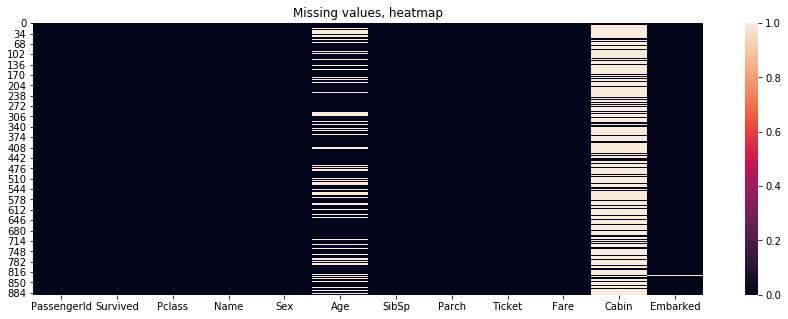

In [112]:
plt.figure(figsize=FIG_SIZE);
sns.heatmap(train.isna().astype(int));
plt.title('Missing values, heatmap');

In [111]:
train.isna().mean() * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

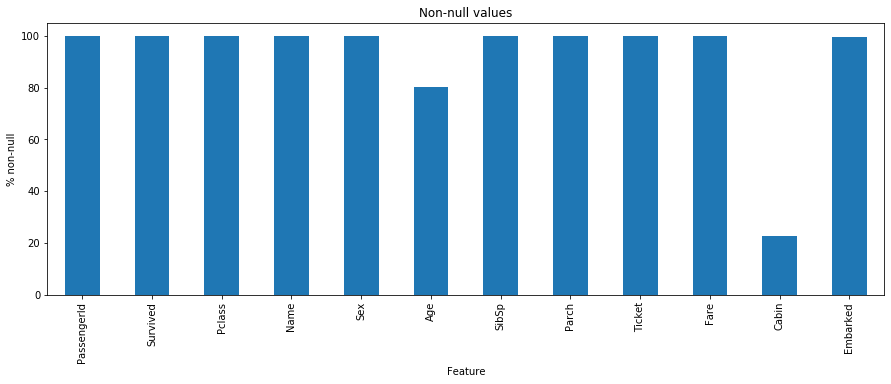

In [110]:
plt.figure(figsize=FIG_SIZE)
(100 - train.isna().mean() * 100).plot.bar();
plt.title('Non-null values');
plt.ylabel('% non-null');
plt.xlabel('Feature');

Age, Cabin, and Embarked all have missing values, with cabin having the most amount of missing values.

## Survived

### Distribution of 'Survived' classes in training data

0    61.616162
1    38.383838
Name: Survived, dtype: float64


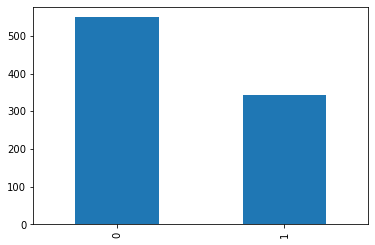

In [57]:
print(train['Survived'].value_counts() / len(train) * 100)
train['Survived'].value_counts().plot.bar();

The training data has class imbalance, but the imbalance is not severe.

## SibSp

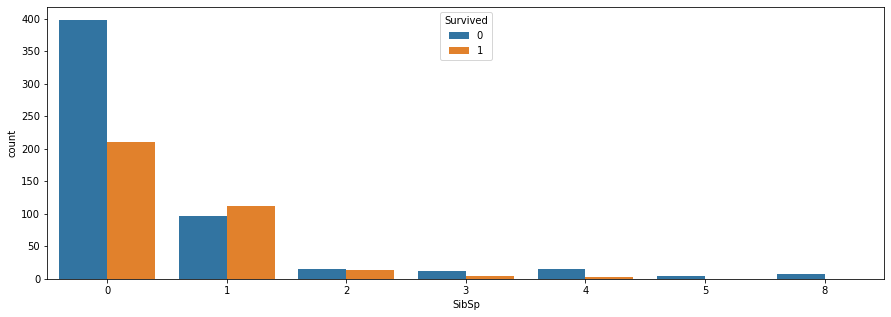

In [122]:
plt.figure(figsize=FIG_SIZE);
sns.countplot(data=train, x='SibSp', hue='Survived');

## Sex

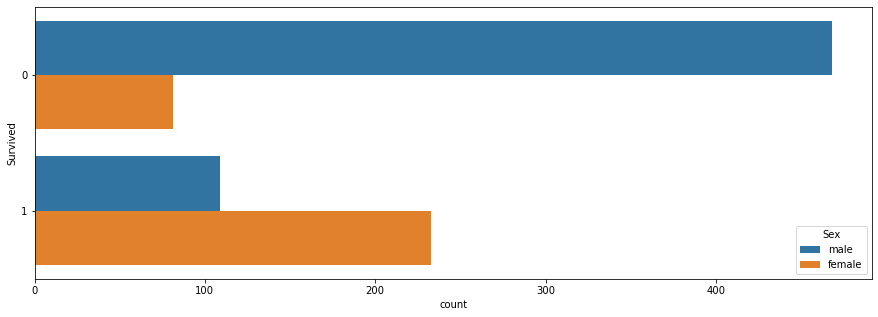

In [120]:
plt.figure(figsize=FIG_SIZE);
sns.countplot(data=train, y='Survived', hue='Sex');

Survival rate for males is much lower than females.

## Pclass

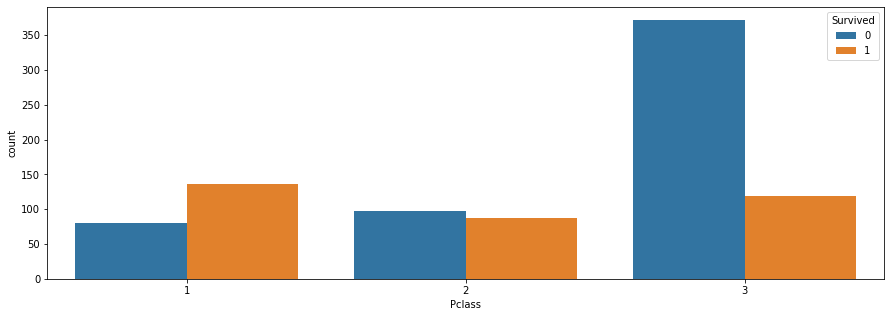

In [140]:
plt.figure(figsize=FIG_SIZE);
sns.countplot(data=train, x='Pclass', hue='Survived');

## Cabin

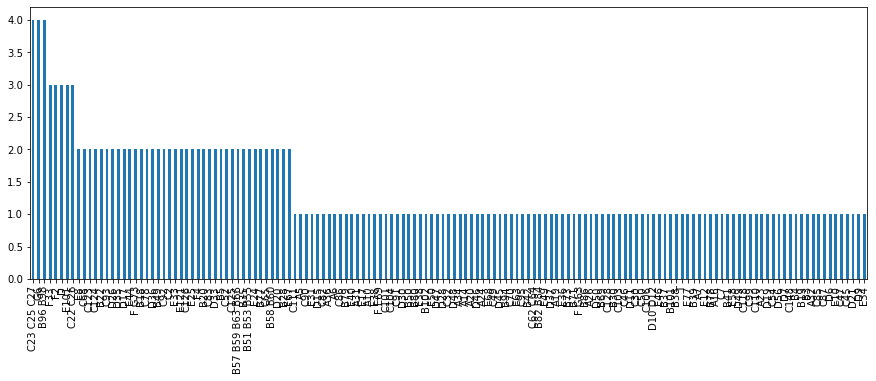

In [131]:
# plt.figure(figsize=FIG_SIZE);
# sns.countplot(data=train, x='Cabin', hue='Survived', palette="plasma_r");
train['Cabin'].value_counts().sort_values(ascending=False).plot.bar(figsize=FIG_SIZE);

## Fare

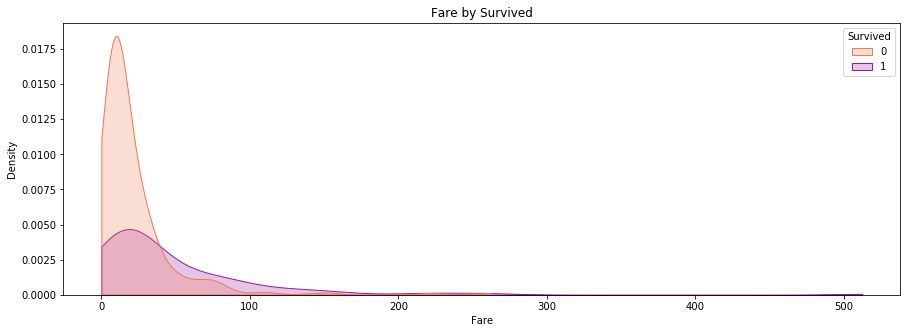

In [48]:
plt.figure(figsize=FIG_SIZE);
kde = sns.kdeplot(x="Fare", data=train, cut=0, hue="Survived", fill=True, legend=True, palette="plasma_r")
kde.title.set_text("Fare by Survived")

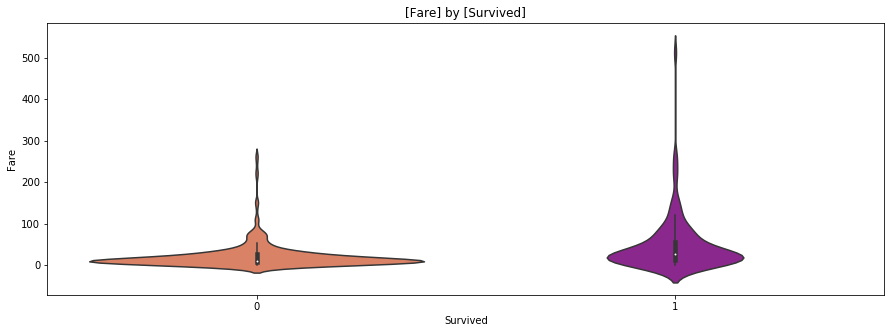

In [58]:
plt.figure(figsize=FIG_SIZE);
sns.violinplot(data=train, x='Survived', y='Fare', palette="plasma_r");
plt.title("[Fare] by [Survived]");

## Age

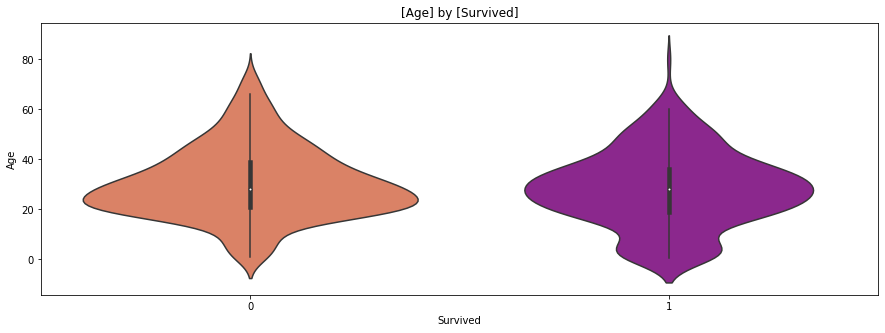

In [37]:
plt.figure(figsize=FIG_SIZE);
sns.violinplot(data=train, x='Survived', y='Age', palette="plasma_r");
plt.title("[Age] by [Survived]");

What's the survival rate for each age group?

# 4. Feature Engineering

## Name -> Title

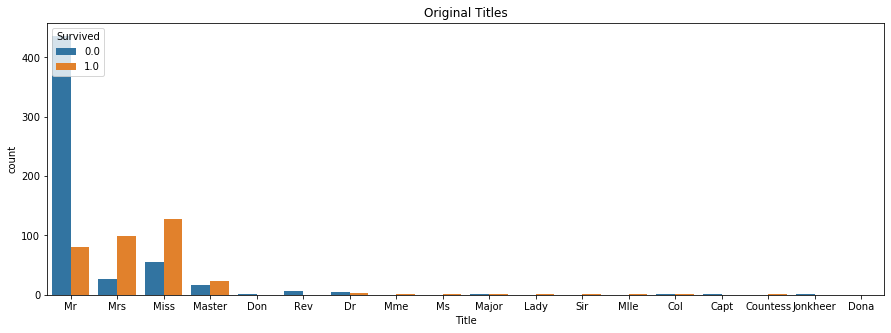

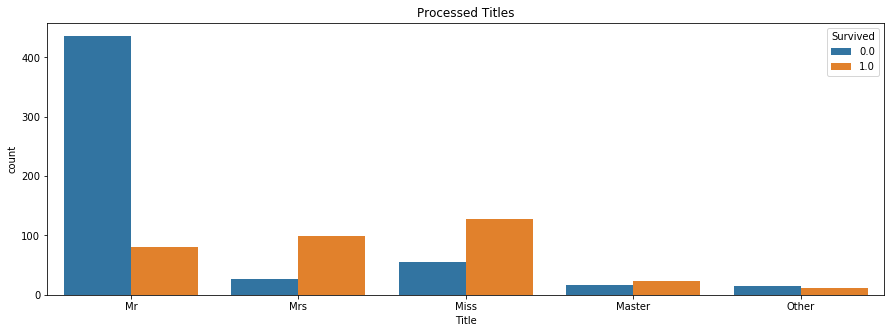

In [181]:
comb['Title'] = comb['Name']
comb['Title'] = comb['Name'].str.extract('([A-Za-z]+)\.', expand=True)

plt.figure(figsize=FIG_SIZE)
sns.countplot(data=comb, x='Title', hue='Survived').set(title = 'Original Titles');

# replace least common titles with 'Other'
title_counts = comb['Title'].value_counts()
top_names = title_counts[title_counts > 10].index
comb['Title'] = comb['Title'].apply(lambda x: x if x in top_names else 'Other')

# plot
plt.figure(figsize=FIG_SIZE)
sns.countplot(data=comb, x='Title', hue='Survived').set(title = 'Processed Titles');

if 'Title' not in nominal_features:
    nominal_features.append('Title')
    nominal_features.remove('Name')

## Filling Missing Cabin Names

In [163]:
comb['Cabin'] = comb['Cabin'].fillna(value='N')

## Convert Fare to Categorical Value

## One-Hot Encode Categorical Values

In [188]:
nominal_features.remove('Ticket') # currently unused
nominal_features.remove('Cabin') # currently unused

In [196]:
comb[nominal_features].head()

,Sex,Embarked,Title
0,male,S,Mr
1,female,C,Mrs
2,female,S,Miss
3,female,S,Mrs
4,male,S,Mr


In [326]:
# copy processed features
df_full = comb[numeric_features + nominal_features].copy()

# one-hot encode nominal features and drop original unencoded features
df_full = pd.concat([df_full, pd.get_dummies(data = df_full[nominal_features])], axis=1)
df_full = df_full.drop(nominal_features, 1)

# print
print(df_full.shape)
df_full.head()

(1309, 15)


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0,0
1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,1,0
2,3,26.0,0,0,7.9250,1,0,0,0,1,0,1,0,0,0
3,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,1,0
4,3,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,0,0


## Imputation of Missing Values

In [327]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 5)
df_full.loc[:, :] = imputer.fit_transform(df_full.values)

In [328]:
# check for nulls
df_full.isna().mean() * 100

Pclass          0.0
Age             0.0
SibSp           0.0
Parch           0.0
Fare            0.0
Sex_female      0.0
Sex_male        0.0
Embarked_C      0.0
Embarked_Q      0.0
Embarked_S      0.0
Title_Master    0.0
Title_Miss      0.0
Title_Mr        0.0
Title_Mrs       0.0
Title_Other     0.0
dtype: float64

## Create training and test sets

In [329]:
# create training and test set
features = df_full.columns
target = 'Survived'

In [339]:
df_full[target] = comb[target] # add target
df_full['PassengerId'] = comb['PassengerId'] # add ID

In [340]:
df_train = df_full[:train.shape[0]]
df_test = df_full[train.shape[0]:]

## Setup training & validation sets

In [341]:
X = df_train[features].values
y = df_train[target].values

In [342]:
TRAIN_SIZE = 0.7
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=TRAIN_SIZE, shuffle=True)

# initial modeling (no feature engineering)

In [343]:
def plot_results_accuracy(results):
    plt.plot(results, marker='o');
    plt.xlabel('split');
    plt.ylabel('accuracy');
    plt.title('Stratified K Fold Accuracy');
    print("Score w/ 95 pct CI: %0.2f (+/- %0.2f)" % (results.mean(), results.std() * 2))

In [344]:
# model_results = {}

## dummy classifier

In [345]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(X_train, y_train)
acc = clf.score(X_val, y_val)
print('dummy classifier accuracy:', round(acc, 2))

dummy classifier accuracy: 0.58


## logistic regression

In [346]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
acc = lr.score(X_val, y_val)
print('logistic regression classifier accuracy:', round(acc, 2))

logistic regression classifier accuracy: 0.82


Score w/ 95 pct CI: 0.83 (+/- 0.07)


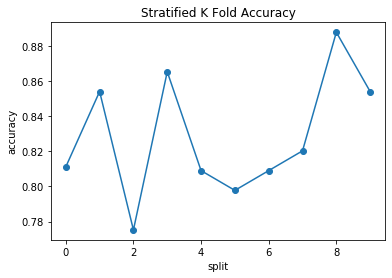

In [347]:
# create a stratified k fold object
stratkfold = StratifiedKFold(n_splits = 10, shuffle = False)

# perform cross validation across the N_SPLITS stratified folds
results = cross_val_score(lr, X, y, cv = stratkfold, scoring = 'accuracy')

plot_results_accuracy(results)

In [348]:
X_test = df_test[features].values
y_pred = lr.predict(X_test).astype(int).flatten()

submission = pd.DataFrame(
    { 
        'PassengerId': df_test['PassengerId'], 
        'Survived': y_pred
    }
)
submission.to_csv("submission_logistic_regression.csv", index=False)

## random forest

Train a random forest to start, as a baseline classifier, to have something to compare the neural network performance with. 

Score w/ 95 pct CI: 0.81 (+/- 0.07)


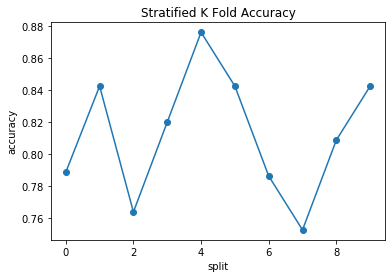

In [311]:
# create RF model
rfc = RandomForestClassifier(n_estimators=100)

# create a stratified k fold object
stratkfold = StratifiedKFold(n_splits = 10, shuffle = False)

# perform cross validation across the N_SPLITS stratified folds
results = cross_val_score(rfc, X, y, cv = stratkfold, scoring = 'accuracy')

plot_results_accuracy(results)

# SVM

Score w/ 95 pct CI: 0.68 (+/- 0.09)


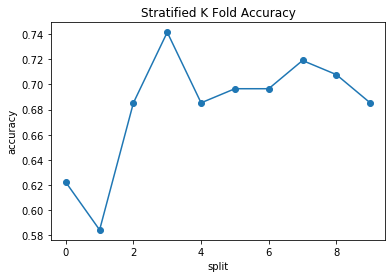

In [312]:
# create model
svc = SVC()

# create a stratified k fold object
stratkfold = StratifiedKFold(n_splits = 10, shuffle = False)

# perform cross validation across the N_SPLITS stratified folds
results = cross_val_score(svc, X, y, cv = stratkfold)

plot_results_accuracy(results)

SVC performance is much worse than the random forest classifier.

# neural network

Train a simple, unoptimized neural network to check it's performance.

In [306]:
## parameters
BATCH_SIZE = 16
EPOCHS = 100
N_SPLITS = 5

In [307]:
# helper functions

def run_cv_on_estimator(build_fn, x_train, y_train, 
                        epochs = EPOCHS, 
                        batch_size = BATCH_SIZE, 
                        n_splits = N_SPLITS, 
                        shuffle = False, 
                        scoring = 'accuracy'):

    # we're going to use sklearn's cross validation functions, so we'll wrap our keras model in an sklearn model wrapper
    estimator = KerasClassifier(build_fn = create_model_0, epochs = epochs, batch_size = batch_size, verbose = 1)

    # create a stratified k fold object
    stratkfold = StratifiedKFold(n_splits = n_splits, shuffle = shuffle)

    # perform cross validation across the N_SPLITS stratified folds
    results = cross_val_score(estimator, x_train, y_train, cv = stratkfold, scoring = scoring)
    
    return results

## model 0

Model: "titanic_m0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 6)                 96        
_________________________________________________________________
layer_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
output (Dense)               (None, 1)                 7         
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
45/45 [==============================] - 0s 1ms/step - loss: 0.8036 - accuracy: 0.5941
Epoch 2/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6745 - accuracy: 0.6517
Epoch 3/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6260 - accuracy: 0.6784
Epoch 4/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6089 - accuracy:

45/45 [==============================] - 0s 2ms/step - loss: 0.3980 - accuracy: 0.8343
Epoch 76/100
45/45 [==============================] - 0s 2ms/step - loss: 0.4036 - accuracy: 0.8272
Epoch 77/100
45/45 [==============================] - 0s 2ms/step - loss: 0.4009 - accuracy: 0.8287
Epoch 78/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3981 - accuracy: 0.8357
Epoch 79/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3993 - accuracy: 0.8357
Epoch 80/100
45/45 [==============================] - 0s 2ms/step - loss: 0.3994 - accuracy: 0.8315
Epoch 81/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4012 - accuracy: 0.8343
Epoch 82/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3999 - accuracy: 0.8343
Epoch 83/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4079 - accuracy: 0.8272
Epoch 84/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4005 - accuracy: 0.8357
Epoch 85/100


45/45 [==============================] - 0s 1ms/step - loss: 0.4167 - accuracy: 0.8121
Epoch 43/100
45/45 [==============================] - 0s 987us/step - loss: 0.4122 - accuracy: 0.8121
Epoch 44/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4092 - accuracy: 0.8205
Epoch 45/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4085 - accuracy: 0.8135
Epoch 46/100
45/45 [==============================] - 0s 938us/step - loss: 0.4034 - accuracy: 0.8191
Epoch 47/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4026 - accuracy: 0.8219
Epoch 48/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4007 - accuracy: 0.8205
Epoch 49/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3992 - accuracy: 0.8247
Epoch 50/100
45/45 [==============================] - 0s 998us/step - loss: 0.3966 - accuracy: 0.8163
Epoch 51/100
45/45 [==============================] - 0s 972us/step - loss: 0.3945 - accuracy: 0.8303
Epoch

45/45 [==============================] - 0s 1ms/step - loss: 0.4866 - accuracy: 0.7882
Epoch 16/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4770 - accuracy: 0.7882
Epoch 17/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4640 - accuracy: 0.8107
Epoch 18/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4602 - accuracy: 0.8107
Epoch 19/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4590 - accuracy: 0.8149
Epoch 20/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4522 - accuracy: 0.8163
Epoch 21/100
45/45 [==============================] - 0s 984us/step - loss: 0.4491 - accuracy: 0.8107
Epoch 22/100
45/45 [==============================] - 0s 988us/step - loss: 0.4464 - accuracy: 0.8163
Epoch 23/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4429 - accuracy: 0.8163
Epoch 24/100
45/45 [==============================] - 0s 979us/step - loss: 0.4432 - accuracy: 0.8247
Epoch 2

45/45 [==============================] - 0s 1ms/step - loss: 0.3843 - accuracy: 0.8429
Epoch 97/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3833 - accuracy: 0.8401
Epoch 98/100
45/45 [==============================] - 0s 972us/step - loss: 0.3817 - accuracy: 0.8387
Epoch 99/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3834 - accuracy: 0.8457
Epoch 100/100
12/12 [==============================] - 0s 864us/step
Model: "titanic_m0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 6)                 96        
_________________________________________________________________
layer_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
output (Dense)               (None, 1)                 7         
Total params: 145
Trainable params: 145
Non-trainable params

45/45 [==============================] - 0s 966us/step - loss: 0.4114 - accuracy: 0.8275
Epoch 70/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4064 - accuracy: 0.8345
Epoch 71/100
45/45 [==============================] - 0s 991us/step - loss: 0.4076 - accuracy: 0.8275
Epoch 72/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4058 - accuracy: 0.8345
Epoch 73/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4034 - accuracy: 0.8317
Epoch 74/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4079 - accuracy: 0.8289
Epoch 75/100
45/45 [==============================] - 0s 945us/step - loss: 0.4029 - accuracy: 0.8289
Epoch 76/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4013 - accuracy: 0.8373
Epoch 77/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4043 - accuracy: 0.8303
Epoch 78/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4001 - accuracy: 0.8289
Epoch 7

45/45 [==============================] - 0s 1ms/step - loss: 0.4057 - accuracy: 0.8443
Epoch 43/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4048 - accuracy: 0.8443
Epoch 44/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4043 - accuracy: 0.8443
Epoch 45/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4000 - accuracy: 0.8429
Epoch 46/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4069 - accuracy: 0.8373
Epoch 47/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4010 - accuracy: 0.8443
Epoch 48/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4070 - accuracy: 0.8415
Epoch 49/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4004 - accuracy: 0.8443
Epoch 50/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3984 - accuracy: 0.8471
Epoch 51/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4053 - accuracy: 0.8429
Epoch 52/100


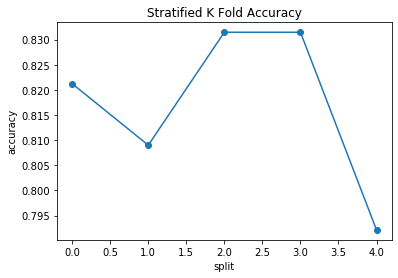

In [308]:
def create_model_0():
    model = keras.Sequential(name="titanic_m0")
    model.add(keras.layers.Input(shape=X_train.shape[1], name='input'))
    model.add(keras.layers.Dense(6, activation="tanh", name="layer_1"))
    model.add(keras.layers.Dense(6, activation="tanh", name="layer_2"))
    model.add(keras.layers.Dense(1, activation="sigmoid", name="output"))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

results = run_cv_on_estimator(create_model_0, X, y)
plot_results_accuracy(results)

So the variance seems to be quite high, as the accuracy is quite different for each fold (i.e. the standard deviation of the accuracy across training folds is not close to 0).

What can we do about this? **Apply regularization for starters!**

# model 1 - L2 regularization

Model: "titanic_m0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 6)                 96        
_________________________________________________________________
layer_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
output (Dense)               (None, 1)                 7         
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
45/45 [==============================] - 0s 1ms/step - loss: 0.8805 - accuracy: 0.3848
Epoch 2/100
45/45 [==============================] - 0s 2ms/step - loss: 0.7266 - accuracy: 0.4817
Epoch 3/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6309 - accuracy: 0.6573
Epoch 4/100
45/45 [==============================] - 0s 2ms/step - loss: 0.6120 - accuracy:

45/45 [==============================] - 0s 1ms/step - loss: 0.4340 - accuracy: 0.8216
Epoch 76/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4294 - accuracy: 0.8244
Epoch 77/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4278 - accuracy: 0.8216
Epoch 78/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4274 - accuracy: 0.8230
Epoch 79/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4293 - accuracy: 0.8202
Epoch 80/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4244 - accuracy: 0.8258
Epoch 81/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4213 - accuracy: 0.8258
Epoch 82/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4217 - accuracy: 0.8230
Epoch 83/100
45/45 [==============================] - 0s 903us/step - loss: 0.4212 - accuracy: 0.8230
Epoch 84/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4131 - accuracy: 0.8301
Epoch 85/10

45/45 [==============================] - 0s 1ms/step - loss: 0.3828 - accuracy: 0.8471
Epoch 49/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3797 - accuracy: 0.8457
Epoch 50/100
45/45 [==============================] - 0s 980us/step - loss: 0.3810 - accuracy: 0.8513
Epoch 51/100
45/45 [==============================] - 0s 980us/step - loss: 0.3848 - accuracy: 0.8429
Epoch 52/100
45/45 [==============================] - 0s 986us/step - loss: 0.3805 - accuracy: 0.8499
Epoch 53/100
45/45 [==============================] - 0s 993us/step - loss: 0.3776 - accuracy: 0.8471
Epoch 54/100
45/45 [==============================] - 0s 965us/step - loss: 0.3855 - accuracy: 0.8513
Epoch 55/100
45/45 [==============================] - 0s 895us/step - loss: 0.3752 - accuracy: 0.8541
Epoch 56/100
45/45 [==============================] - 0s 989us/step - loss: 0.3746 - accuracy: 0.8513
Epoch 57/100
45/45 [==============================] - 0s 954us/step - loss: 0.3758 - accuracy: 0.85

45/45 [==============================] - 0s 1ms/step - loss: 0.4819 - accuracy: 0.7994
Epoch 22/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4752 - accuracy: 0.8008
Epoch 23/100
45/45 [==============================] - 0s 984us/step - loss: 0.4705 - accuracy: 0.8036
Epoch 24/100
45/45 [==============================] - 0s 964us/step - loss: 0.4711 - accuracy: 0.8065
Epoch 25/100
45/45 [==============================] - 0s 937us/step - loss: 0.4654 - accuracy: 0.8121
Epoch 26/100
45/45 [==============================] - 0s 918us/step - loss: 0.4630 - accuracy: 0.8050
Epoch 27/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4619 - accuracy: 0.8036
Epoch 28/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4614 - accuracy: 0.8107
Epoch 29/100
45/45 [==============================] - 0s 974us/step - loss: 0.4595 - accuracy: 0.8093
Epoch 30/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4558 - accuracy: 0.8107
Epo

Epoch 1/100
45/45 [==============================] - 0s 965us/step - loss: 0.8592 - accuracy: 0.3156
Epoch 2/100
45/45 [==============================] - 0s 987us/step - loss: 0.7386 - accuracy: 0.3647
Epoch 3/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6796 - accuracy: 0.6073
Epoch 4/100
45/45 [==============================] - 0s 915us/step - loss: 0.6491 - accuracy: 0.6283
Epoch 5/100
45/45 [==============================] - 0s 894us/step - loss: 0.6329 - accuracy: 0.6311
Epoch 6/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6221 - accuracy: 0.6971
Epoch 7/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6160 - accuracy: 0.6957
Epoch 8/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6120 - accuracy: 0.6971
Epoch 9/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6087 - accuracy: 0.7013
Epoch 10/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6065 - accuracy: 0.7013
E

45/45 [==============================] - 0s 1ms/step - loss: 0.4890 - accuracy: 0.7742
Epoch 83/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4882 - accuracy: 0.7728
Epoch 84/100
45/45 [==============================] - 0s 2ms/step - loss: 0.4887 - accuracy: 0.7728
Epoch 85/100
45/45 [==============================] - 0s 2ms/step - loss: 0.4879 - accuracy: 0.7728
Epoch 86/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4894 - accuracy: 0.7714
Epoch 87/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4886 - accuracy: 0.7742
Epoch 88/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4888 - accuracy: 0.7770
Epoch 89/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4892 - accuracy: 0.7770
Epoch 90/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4873 - accuracy: 0.7742
Epoch 91/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4883 - accuracy: 0.7756
Epoch 92/100


45/45 [==============================] - 0s 1ms/step - loss: 0.4100 - accuracy: 0.8345
Epoch 56/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4146 - accuracy: 0.8317
Epoch 57/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4079 - accuracy: 0.8303
Epoch 58/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4055 - accuracy: 0.8345
Epoch 59/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4059 - accuracy: 0.8331
Epoch 60/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4047 - accuracy: 0.8345
Epoch 61/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4045 - accuracy: 0.8317
Epoch 62/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4095 - accuracy: 0.8233
Epoch 63/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4035 - accuracy: 0.8345
Epoch 64/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4045 - accuracy: 0.8345
Epoch 65/100


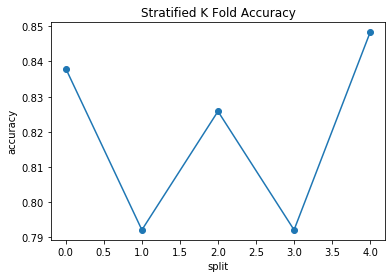

In [309]:
def create_model_1():
    model = keras.Sequential(name="titanic_m0")
    
    model.add(keras.layers.Input(shape=X_train.shape[1], name='input'))
    
    model.add(keras.layers.Dense(6, activation="tanh", name="layer_1", kernel_regularizer=l2(1)))
    
    model.add(keras.layers.Dense(6, activation="tanh", name="layer_2", kernel_regularizer=l2(1)))
    
    model.add(keras.layers.Dense(1, activation="sigmoid", name="output"))
    
    model.summary()
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

results = run_cv_on_estimator(create_model_1, X, y)
plot_results_accuracy(results)

# model 2 - more complex model + L2 & dropout regularization 

Model: "titanic_m0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 6)                 96        
_________________________________________________________________
layer_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
output (Dense)               (None, 1)                 7         
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
45/45 [==============================] - 0s 1ms/step - loss: 0.7169 - accuracy: 0.4775
Epoch 2/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6484 - accuracy: 0.6854
Epoch 3/100
45/45 [==============================] - 0s 2ms/step - loss: 0.6292 - accuracy: 0.6854
Epoch 4/100
45/45 [==============================] - 0s 2ms/step - loss: 0.6193 - accuracy:

45/45 [==============================] - 0s 2ms/step - loss: 0.3887 - accuracy: 0.8469
Epoch 76/100
45/45 [==============================] - 0s 2ms/step - loss: 0.3874 - accuracy: 0.8427
Epoch 77/100
45/45 [==============================] - 0s 2ms/step - loss: 0.3902 - accuracy: 0.8427
Epoch 78/100
45/45 [==============================] - 0s 2ms/step - loss: 0.3893 - accuracy: 0.8441
Epoch 79/100
45/45 [==============================] - 0s 2ms/step - loss: 0.3888 - accuracy: 0.8427
Epoch 80/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3891 - accuracy: 0.8413
Epoch 81/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3857 - accuracy: 0.8497
Epoch 82/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3886 - accuracy: 0.8441
Epoch 83/100
45/45 [==============================] - 0s 927us/step - loss: 0.3861 - accuracy: 0.8469
Epoch 84/100
45/45 [==============================] - 0s 916us/step - loss: 0.3950 - accuracy: 0.8413
Epoch 85/

45/45 [==============================] - 0s 1ms/step - loss: 0.4285 - accuracy: 0.8149
Epoch 49/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4308 - accuracy: 0.8163
Epoch 50/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4297 - accuracy: 0.8149
Epoch 51/100
45/45 [==============================] - 0s 933us/step - loss: 0.4270 - accuracy: 0.8149
Epoch 52/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4264 - accuracy: 0.8219
Epoch 53/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4251 - accuracy: 0.8121
Epoch 54/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4223 - accuracy: 0.8149
Epoch 55/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4229 - accuracy: 0.8149
Epoch 56/100
45/45 [==============================] - 0s 956us/step - loss: 0.4199 - accuracy: 0.8135
Epoch 57/100
45/45 [==============================] - 0s 922us/step - loss: 0.4208 - accuracy: 0.8205
Epoch 5

45/45 [==============================] - 0s 1ms/step - loss: 0.4257 - accuracy: 0.8275
Epoch 22/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4258 - accuracy: 0.8233
Epoch 23/100
45/45 [==============================] - 0s 985us/step - loss: 0.4246 - accuracy: 0.8191
Epoch 24/100
45/45 [==============================] - 0s 951us/step - loss: 0.4202 - accuracy: 0.8261
Epoch 25/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4208 - accuracy: 0.8247
Epoch 26/100
45/45 [==============================] - 0s 966us/step - loss: 0.4173 - accuracy: 0.8317
Epoch 27/100
45/45 [==============================] - 0s 899us/step - loss: 0.4147 - accuracy: 0.8317
Epoch 28/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4151 - accuracy: 0.8303
Epoch 29/100
45/45 [==============================] - 0s 984us/step - loss: 0.4110 - accuracy: 0.8429
Epoch 30/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4103 - accuracy: 0.8303
Epo

Epoch 1/100
45/45 [==============================] - 0s 915us/step - loss: 0.7070 - accuracy: 0.4727
Epoch 2/100
45/45 [==============================] - 0s 907us/step - loss: 0.6619 - accuracy: 0.6297
Epoch 3/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6572 - accuracy: 0.6325
Epoch 4/100
45/45 [==============================] - 0s 912us/step - loss: 0.6565 - accuracy: 0.6325
Epoch 5/100
45/45 [==============================] - 0s 915us/step - loss: 0.6559 - accuracy: 0.6353
Epoch 6/100
45/45 [==============================] - 0s 972us/step - loss: 0.6544 - accuracy: 0.6353
Epoch 7/100
45/45 [==============================] - 0s 987us/step - loss: 0.6516 - accuracy: 0.6339
Epoch 8/100
45/45 [==============================] - 0s 994us/step - loss: 0.6166 - accuracy: 0.6353
Epoch 9/100
45/45 [==============================] - 0s 949us/step - loss: 0.5816 - accuracy: 0.6494
Epoch 10/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5545 - accuracy: 

45/45 [==============================] - 0s 1ms/step - loss: 0.4127 - accuracy: 0.8331
Epoch 83/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4103 - accuracy: 0.8345
Epoch 84/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4080 - accuracy: 0.8317
Epoch 85/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4128 - accuracy: 0.8387
Epoch 86/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4134 - accuracy: 0.8219
Epoch 87/100
45/45 [==============================] - 0s 940us/step - loss: 0.4087 - accuracy: 0.8331
Epoch 88/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4116 - accuracy: 0.8345
Epoch 89/100
45/45 [==============================] - 0s 984us/step - loss: 0.4064 - accuracy: 0.8359
Epoch 90/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4087 - accuracy: 0.8401
Epoch 91/100
45/45 [==============================] - 0s 936us/step - loss: 0.4133 - accuracy: 0.8289
Epoch 9

45/45 [==============================] - 0s 1ms/step - loss: 0.4252 - accuracy: 0.8345
Epoch 56/100
45/45 [==============================] - 0s 931us/step - loss: 0.4228 - accuracy: 0.8345
Epoch 57/100
45/45 [==============================] - 0s 932us/step - loss: 0.4244 - accuracy: 0.8289
Epoch 58/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4247 - accuracy: 0.8331
Epoch 59/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4287 - accuracy: 0.8275
Epoch 60/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4210 - accuracy: 0.8303
Epoch 61/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4214 - accuracy: 0.8289
Epoch 62/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4237 - accuracy: 0.8331
Epoch 63/100
45/45 [==============================] - 0s 986us/step - loss: 0.4204 - accuracy: 0.8289
Epoch 64/100
45/45 [==============================] - 0s 921us/step - loss: 0.4209 - accuracy: 0.8345
Epoch

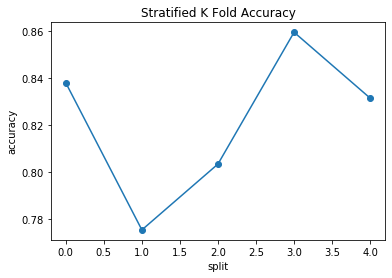

In [310]:
def create_model_2():
    model = Sequential()
    model.add(Input(shape=X_train.shape[1], name='Input_'))
    model.add(Dense(8, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.001)))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

    model.summary()
    optimize = Adam(lr = 0.0001)
    model.compile(optimizer = optimize, 
                       loss = 'binary_crossentropy', 
                       metrics = ['accuracy'])

results = run_cv_on_estimator(create_model_2, X, y)
plot_results_accuracy(results)

So the model's accuracy on the validation set (82.3%) is close to the training accuracy (84.1%), which means the model doesn't seem to be over-fitting, but the model's bias is about the same as the random forest (82.3%)

However, the question remains could we do better?

Options to explore:
- Feature engineering
- Standardization (i.e. normalization of inputs)?
- Train a more complex NN architecture
    - Train a bigger model, add more layers, add more nodes
- Hyper-parameter tuning

In [345]:
y_pred_test_proba = model.predict(X_test)
y_pred_test = (y_pred_test_proba > 0.5).astype(int).flatten()

submission = pd.DataFrame(
    { 
        'PassengerId': test.PassengerId, 
        'Survived': y_pred_test
    }
)
submission.to_csv("submission_DL_0.csv", index=False)